# Battle of Neighbourhoods - Final

This notebook consist of six parts.This notebook is continued version of "The Battle of Neighborhoods (Week 1)"
    
   **1 Introduction/Business Problem**
   
       1.a Discussion of the business problem and the audience who would be interested in this project.
   
   **2 Data Section**
       
       2.a What data is used?
       2.b Importing Libraries
       2.c Credentials and Core location
       2.d Search for hotel & restaurant within 1 KM
       2.e Location of Hotels
   
   **3 Methodology Section**
   
       3.a Removing Outlier - Hotel Bharani
       3.b How Far are hotels from the core location
       3.c Explore for other venues around Kanyakumari
       3.d Extract Venues using Search Queries
       3.e Location of all venues
       3.f How far are venues from the core location?
       3.g Venue Categories
       3.h Rating of all Venues
       3.i Number of Tips for all Venues
       3.j Extracting Rated and Tips Venues
       3.k Final list of Venues
       3.l Clustering based on venues
       3.m Center of all clusters & Midpoint of all venues
   
   **4 Results Section**
   
       4.a My hotel location
       4.b Top Rated Venues
       4.c Spot my hotel against others
       4.d Few more Stats
   
   **5 Discussion Section**
   
   **6 Conclusion Section** 

## 1. Introduction/Business Problem

### Discussion of the business problem and the audience who would be interested in this project.

#### Something about the tourist place - KANYAKUMARI,INDIA 

I am from kanyakumari,a beautiful tourist spot in southern India.Kanyakumari is a coastal town in the state of Tamil Nadu on India's southern tip. Jutting into the Laccadive Sea, the town was known as Cape Comorin during British rule and is popular for watching sunrise and sunset over the ocean.Kanyakumari is also home to the Statue of the Saint Poet Thiruvalluvar, one of the greatest Tamil poets in India. Standing at a massive height of 133 feet, the statue is one of the biggest in the entire Asian subcontinent and is the result of the hard work of over 500 sculptors. Other historic sights that you can visit in Kanyakumari include the Padmanabhapuram Palace, the Vattakottai Fort, and the Gandhi Memorial.

#### Opening of Hotel/Restaurant Shop

Coming down to business problem,I would like to open a **hotel/restaurant** near beach side.As it is a famous tourist spot,there is already lots of attention towards it.I know there will be many competitors in terms of hotel and restauramt.But keeping them in mind,i need to locate my hotel in place where more people are attracted and comfortable for a stay and a good meal.I want to bring foreign and local peoples attention towards my new hotel.I would like to flavour my retaurant recipe with Italian,American,typical south & north indian foods to grab their taste.

*The challenge is to find a **suitable location** for opening a new hotel / restaurant attracted to all local and foreign people in the centre of all famous venues.*

#### Expected / Interested Audience

85% local and 15% foreign peoples visit kanyakumari once in a year.Some people stay for couple of days or more.Also they find some place for hangout or a good meal.Their main focus might be belonging to stay somewhere near to reach venues.Apart from these set of people,students and working professionals are common audience here.So we may need to fascinate them all.

##  2.Data section

### 2.a What data is used?

We will be completely working on **Foursquare data** to explore and try to locate our new hotel where more venues like church, temples,  beach, museums, memorials that are present nearby.

**How will we be solving using this data?**

We will looking for midpoint area of venues to locate our new hotel.Before that our major focus will be on all venues present in and around the core place of kanyakumari.

Just a heads up on how many hotels are distributed now around kanyakumari.We will perform some EDA on hotels & restaurants present in the tourist spot.On furthur notebook we will use Foursquare data to determine other venues as well.

### 2.b Importing Libraries

In [3]:
# Import libraries
import numpy as np # data in a vectorized manner manipulation
import pandas as pd # data analsysis
import requests # HTTP library
from bs4 import BeautifulSoup # scraping library

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # JSON files manipulation

from sklearn.cluster import KMeans # clustering algorithm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print("*********   Loaded library     ***********")

*********   Loaded library     ***********


### 2.c Credentials and Core location

In [4]:
CLIENT_ID = 'XXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXX' # your Foursquare Secret
VERSION = '20191028'
LIMIT = 150

address = "Kanyakumari, Tamil Nadu"

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude =location.latitude   #8.079252 # location.latitude 
longitude =location.longitude #77.5499338 # location.longitude # 

kan='Kanyakumari location : {},{}'.format(latitude,longitude)
print(kan)

Kanyakumari location : 8.079252,77.5499338


### 2.d Search for hotel & restaurant within 1 KM

In [5]:
#Quering for hotel & restaurant

search_query = 'hotel'
search_query_res = 'restaurant'

radius = 1000
url_hotel = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url_restaurant = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query_res, radius, LIMIT)
#url

#### Send the GET Request of hotel & restaurants and examine the results

In [6]:
results_hotel = requests.get(url_hotel).json()
results_restaurant = requests.get(url_restaurant).json()
#results_hotel

#### Get relevant part of JSON and transform it into a *pandas* dataframe

In [7]:
# assign relevant part of JSON to venues
venues_hotel = results_hotel['response']['venues']
venues_restaurant = results_restaurant['response']['venues']

# tranform venues into a dataframe and merging both data
dataframe_hotel = json_normalize(venues_hotel)
dataframe_restaurant = json_normalize(venues_restaurant)

dataframe = pd.concat([dataframe_hotel,dataframe_restaurant])

print("There are {} restaurants and hotels at Kanyakumari".format(dataframe.shape[0]))

There are 37 restaurants and hotels at Kanyakumari


#### Define information of interest and filter dataframe

In [8]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

    
# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

  
# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

#dataframe_filtered
hotels_df=dataframe_filtered[['name','categories','distance','lat','lng','id']]
hotels_df.head()

,name,categories,distance,lat,lng,id
0,Hotel SeaView,Hotel,371,8.082333,77.551217,4cd42e2c558a370412d0c5a6
1,Hotel Sarvana,Hotel,179,8.080581,77.550861,4db052544df03036e8b9d615
2,Hotel Annapoorna,Indian Restaurant,206,8.080879,77.550835,50ed3a39e4b0ac50005eb3f1
3,Hotel Samudra,Motel,201,8.080642,77.551102,4d3c66e414aa8cfa4641a95e
4,Hotel Trisea,South Indian Restaurant,269,8.081475,77.548969,5030a43ee4b021f7a59c7456


### 2.e Location of Hotels

In [10]:
hotels_map = folium.Map(location=[latitude, longitude], zoom_start=16) # generate map centred around the Kanyakumari

# add a red circle marker to represent the core location of kanyakumari
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Kanyakumari',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(hotels_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(hotels_df.lat, hotels_df.lng, hotels_df.name):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(hotels_map)

# display map
hotels_map

Hotel Bharani (8.076268,77.548670) seems to be outlier.So this will be removed in next section.

## 3.Methodology section

In this sections we will perform some data analysis and EDA to find insight from data.We will try to understand the current stats of all given data.Probably,clustering or centroid of all venues will help us to locate new hotel.

###  3.a Removing Outlier - Hotel Bharani

In [11]:
dataframe_filtered=dataframe_filtered.drop(dataframe_filtered[dataframe_filtered.name =='Hotel Bharani'].index)
hotels_df=dataframe_filtered
print("So Now there are {} hotels & restaurants present in kanyakumari".format(dataframe_filtered.shape[0]))

So Now there are 36 hotels & restaurants present in kanyakumari


### 3.b How Far are hotels from the core location

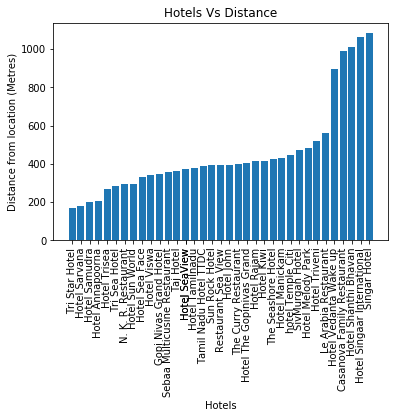

Average distance between hotels and core location is 454 metres


In [13]:
distance_hotel_df=dataframe_filtered[['name','categories','distance','lat','lng']].sort_values('distance')

def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(distance_hotel_df.name))
    plt.bar(distance_hotel_df.name, distance_hotel_df.distance)
    plt.xlabel('Hotels')
    plt.ylabel('Distance from location (Metres)')
    plt.xticks(distance_hotel_df.name,rotation=90)
    plt.title('Hotels Vs Distance')
    plt.show()
plot_bar_x()

print("Average distance between hotels and core location is {} metres".format(int(sum(hotels_df['distance'])/hotels_df.shape[0])))

**Few Take Aways**

* Singar hotel is far than rest of hotels.
    
* Tri Star remains close to the core spot.
    
* 454 metres is average distance from all hotels to core location.
    

### 3.c Explore for other venues around Kanyakumari

A tourist person always wants to visit nearby iconic places.So he wants to reside somewhere nearby to all major venues.We will be exploring more venues around the core location.We will be digging more on main areas or place around 1 km.

In [14]:
radius=1000
url_venues = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
#url_venues

In [15]:
import requests

results_venues = requests.get(url_venues).json()
'There are {} venues around kanyakumari.'.format(len(results_venues['response']['groups'][0]['items']))

'There are 16 venues around kanyakumari.'

Get relevant part of JSON and transform it into a pandas dataframe

In [16]:
items_venues = results_venues['response']['groups'][0]['items']
#items_venues[0]

In [17]:
dataframe_venues = json_normalize(items_venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe_venues.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered_venues = dataframe_venues.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered_venues['venue.categories'] = dataframe_filtered_venues.apply(get_category_type, axis=1)

# clean columns
dataframe_filtered_venues.columns = [col.split('.')[-1] for col in dataframe_filtered_venues.columns]

dataframe_filtered_venues.name

0                 Sunrise Point
1     Vivekananda Rock Memorial
2               End of the Land
3             Kanyakumari Beach
4                Triveni Sangam
5        Sparsa Resorts and Spa
6                 Hotel SeaView
7             Sangam Restautant
8          Thiruvalluvar Statue
9                 Hotel Sarvana
10                   Ferry Boat
11              Gandhi Memorial
12       Kanyakumari Lighthouse
13           The Seashore Hotel
14       Thiruvalluvar Mandapam
15     Kanyakumari Bus Stantion
Name: name, dtype: object

### 3.d Extract Venues using Search Queries

When I searched in google map,I could see there were some venues missing.Temples,Church,Parks and Museums are also more recognized by visitors and local audience.So lets bring their data inside.I am not sure why Foursquare hasnt captured it while trying venue query.

Below is the function to extract many queries at a time by passing them in a single list.

In [18]:
# search query function
search_query_list = ['temple','church','park','museum'] 
radius =1000
temp_df=[]
search_df=[]

def search_query_fn():   
    #Loop to run through urls and from json to pandas
    for i in range(len(search_query_list)):
        url= 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query_list[i], radius, LIMIT)
        
        results=requests.get(url).json()
        venues = results['response']['venues']
        
        #Normalize from json
        dataframe = json_normalize(venues)
        
        #Removing unwanted column headers
        dataframe.columns = [col.split('.')[-1] for col in dataframe.columns]
        temp_df.append(dataframe)
    
    #Loop to append dataframes to single dataframe
    for j in range(len(search_query_list)):
        data=temp_df[j]
        search_df.append(data)

# Function to run loop over queries
search_query_fn()

search_df = pd.concat(search_df,sort=True)
search_df['categories'] = search_df.apply(get_category_type, axis=1)
search_df = pd.DataFrame(search_df[['name','categories','distance','lat','lng','id']])
search_df

,name,categories,distance,lat,lng,id
0,Bhagwati Aman Temple,Temple,127,8.079735,77.550979,4c7110d8d7fab1f7733e60c9
1,Kanyakumari Temple,Temple,209,8.080701,77.551147,5135e0ace4b05b6ad7b6e450
2,hotel Temple Citi,Hotel,448,8.083273,77.549709,58b591732520ae2198572be8
3,Guganateeswara Temple,Temple,891,8.087151,77.548584,59361f0fd48ec1757c7d4ca4
0,St.Anthony's Church,Church,435,8.082916,77.551320,4db2dc880437fa536a056d3e
1,Our Lady Of Ransom Church,Church,680,8.085158,77.551544,4edb6b300e011b46ef9c3af5
0,Triangle Park,Park,8,8.079332,77.549930,5a17c667f96b2c105e79a65e
1,Hotel Melody Park,Hotel,482,8.083571,77.549568,52fbace0498e429e952167c7


#### We will collate venues provided by foursquare and the ones extracted through hitting search query API

In [19]:
# Data extracted from foursquare venues
four_sq_venue=pd.DataFrame(dataframe_filtered_venues[['name','categories','distance','lat','lng','id']])

# Data extracted from search queries
new_venues=pd.DataFrame(search_df)

# Concatenate both dataframe
df_venue=pd.concat([four_sq_venue, new_venues],sort=True)

#### Let us remove hotel & restaurants and get final list of venues.

 We could see that there are some hotels/restaurants in the venues list.So we will remove them from the list.We have them in separate dataframe (*hotels_df*).

In [20]:
to_drop = ['Hotel', 'Restautant','hotel','Resort']
df_venues = df_venue[~df_venue['name'].str.contains('|'.join(to_drop))].reset_index()
print("There are {} venues in kanyakumari".format(df_venues.shape[0]))
df_venues[['name','distance','id']]

There are 17 venues in kanyakumari


,name,distance,id
0,Sunrise Point,135,4f21fd64e4b0717a65eeddc3
1,Vivekananda Rock Memorial,312,4b9cbc7ef964a520e37836e3
2,End of the Land,148,4f22babfe4b0ed339695e61e
3,Kanyakumari Beach,10,4e8d9f944fc653e47d1afef1
4,Triveni Sangam,277,4eb57ae40cd688257829927c
5,Thiruvalluvar Statue,147,4ed9ed9530f83fb79c10cd14
6,Ferry Boat,259,4c71df7857b6a1436f4ec4cc
7,Gandhi Memorial,26,4e8d8fc94fc653e47d19524a
8,Kanyakumari Lighthouse,417,4c711c4334443704e6f5255f
9,Thiruvalluvar Mandapam,466,4cc0142397bc721ec6178967


### 3.e Location of all venues

In [21]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=16) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the Kanyakumari
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='kanyakumari',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(df_venues.lat, df_venues.lng, df_venues.name):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='black',
        #popup=label,
        fill = True,
        fill_color='black',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

All venues seems to be dispersed except seashore areas.

We have listed out number of hotels and venues around kanyakumari.There are **36 Hotels/Restaurant** and **17 Venues**.

### 3.f How far are venues from the core location?

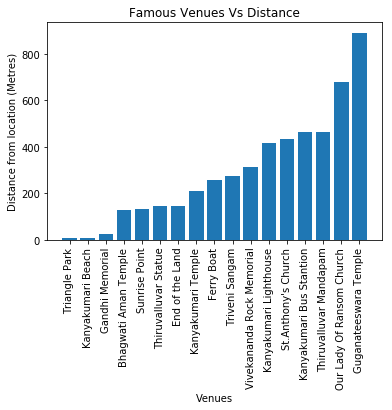

In [22]:
distance_venues_df=df_venues.sort_values('distance')

def plot_bar_venue():
    # this is for plotting purpose
    index = np.arange(len(distance_venues_df.name))
    plt.bar(distance_venues_df.name, distance_venues_df.distance)
    plt.xlabel('Venues')
    plt.ylabel('Distance from location (Metres)')
    plt.xticks(distance_venues_df.name,rotation=90)
    plt.title('Famous Venues Vs Distance')
    plt.show()
plot_bar_venue()


**Few Take Aways**
    
* We could see Kanyakumari beach,Gandhi Memorial,Triangle Park are more closer to our location.
* Guganateswara temple is far than rest of places.
* Bus station is also an important venue which is 465 metres from our location 


### 3.g Venue Categories

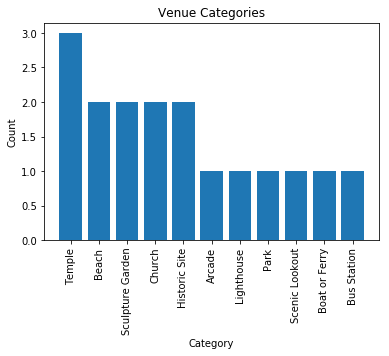

In [23]:
freq_venue=df_venues['categories'].value_counts()
freq_venue=pd.DataFrame(freq_venue).reset_index()
freq_venue.columns=['Category','Count']
freq_venue

def plot_bar_categ():
    # this is for plotting purpose
    index = np.arange(len(freq_venue.Category))
    plt.bar(freq_venue.Category, freq_venue.Count)
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(freq_venue.Category,rotation=90)
    plt.title('Venue Categories')
    plt.show()
plot_bar_categ()


Eventhough we didnt have immense data to consider distribution of categories we could see that **Temple, Beach, Historic sites and Church** are more common venues.

### 3.h Rating of all  Venues

In [24]:
#Rating of venues
rating_df=[]

for k in range(df_venues.shape[0]):
    venue_id=df_venues.id[k]
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    #print(result)
    try:
        #print(df_venues.name[k],result['response']['venue']['rating'])
        rating=result['response']['venue']['rating']
        rating_df.append(rating)
        
    except:
        #print(df_venues.name[k],'This venue has not been rated yet.')
        rating='No Rating Yet'
        rating_df.append(rating)

In [25]:
rate_dict = {'Venue': df_venues.name, 'Rating': rating_df,'distance':df_venues.distance}
rate_df=pd.DataFrame(rate_dict)
rate_df

,Venue,Rating,distance
0,Sunrise Point,8.5,135
1,Vivekananda Rock Memorial,8.2,312
2,End of the Land,7.5,148
3,Kanyakumari Beach,6.9,10
4,Triveni Sangam,6.9,277
5,Thiruvalluvar Statue,No Rating Yet,147
6,Ferry Boat,No Rating Yet,259
7,Gandhi Memorial,5.4,26
8,Kanyakumari Lighthouse,No Rating Yet,417
9,Thiruvalluvar Mandapam,No Rating Yet,466


### 3.i Number of Tips for all Venues

In [26]:
tips_df=[]

for k in range(df_venues.shape[0]):
    venue_id=df_venues.id[k]
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    
    #print(result['response']['venue']['tips']['count'],result['response']['venue'])
    tips=result['response']['venue']['tips']['count']
    tips_df.append(tips)


In [27]:
tips_dict = {'Venue': df_venues.name, 'Tips': tips_df,'distance':df_venues.distance}
tips=pd.DataFrame(tips_dict)
tips=tips.sort_values('Tips',ascending = False)
tips

,Venue,Tips,distance
1,Vivekananda Rock Memorial,16,312
0,Sunrise Point,4,135
3,Kanyakumari Beach,3,10
6,Ferry Boat,3,259
7,Gandhi Memorial,2,26
2,End of the Land,2,148
10,Kanyakumari Bus Stantion,1,465
8,Kanyakumari Lighthouse,1,417
4,Triveni Sangam,1,277
5,Thiruvalluvar Statue,0,147


### 3.j Extracting Rated and Tips Venues

In [28]:
# Add Tips column to Rating Dataframe
rate_df['Tips']=tips['Tips']

#Lets take values of only rated venues
only_rated_tips = rate_df[(rate_df['Rating']!='No Rating Yet') | (rate_df['Tips']!=0)]

only_rated_tips.reset_index(inplace = True,drop = True) 
only_rated_tips

,Venue,Rating,distance,Tips
0,Sunrise Point,8.5,135,4
1,Vivekananda Rock Memorial,8.2,312,16
2,End of the Land,7.5,148,2
3,Kanyakumari Beach,6.9,10,3
4,Triveni Sangam,6.9,277,1
5,Ferry Boat,No Rating Yet,259,3
6,Gandhi Memorial,5.4,26,2
7,Kanyakumari Lighthouse,No Rating Yet,417,1
8,Kanyakumari Bus Stantion,No Rating Yet,465,1


### 3.k Final list of Venues

In [29]:
rated_list=[]
for i in range(len(only_rated_tips)):
    rated_tip_temp=only_rated_tips['Venue'][i]
    rated_list.append(rated_tip_temp)

#Masking all values present in list
mask = df_venues['name'].isin(rated_list)

final_venues = df_venues[mask]
#final_venues['location']=final_venues['lat'].astype(str).str.cat(final_venues['lng'].astype(str), sep=' - ')
final_venues.reset_index(inplace = True,drop = True) 

final_venues

,index,categories,distance,id,lat,lng,name
0,0,Beach,135,4f21fd64e4b0717a65eeddc3,8.079398,77.551158,Sunrise Point
1,1,Sculpture Garden,312,4b9cbc7ef964a520e37836e3,8.080707,77.552362,Vivekananda Rock Memorial
2,2,Arcade,148,4f22babfe4b0ed339695e61e,8.078479,77.551035,End of the Land
3,3,Beach,10,4e8d9f944fc653e47d1afef1,8.079311,77.550005,Kanyakumari Beach
4,4,Historic Site,277,4eb57ae40cd688257829927c,8.078860,77.547448,Triveni Sangam
5,10,Boat or Ferry,259,4c71df7857b6a1436f4ec4cc,8.080931,77.551561,Ferry Boat
6,11,Historic Site,26,4e8d8fc94fc653e47d19524a,8.079021,77.549976,Gandhi Memorial
7,12,Lighthouse,417,4c711c4334443704e6f5255f,8.081389,77.546820,Kanyakumari Lighthouse
8,15,Bus Station,465,4edc1b4846907c1b44ba0ed8,8.082652,77.547469,Kanyakumari Bus Stantion


### 3.l Clustering based on venues

Now lets do some prediction to locate our new hotel in centre of final list of venues.

In [30]:
# one hot encoding
neighbor_onehot = pd.get_dummies(final_venues[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
neighbor_onehot['name'] = final_venues['name'] 

# move neighborhood column to the first column
fixed_columns = [neighbor_onehot.columns[-1]] + list(neighbor_onehot.columns[:-1])
neighbor_onehot = neighbor_onehot[fixed_columns]

neighbor_onehot.head()

,name,Arcade,Beach,Boat or Ferry,Bus Station,Historic Site,Lighthouse,Sculpture Garden
0,Sunrise Point,0,1,0,0,0,0,0
1,Vivekananda Rock Memorial,0,0,0,0,0,0,1
2,End of the Land,1,0,0,0,0,0,0
3,Kanyakumari Beach,0,1,0,0,0,0,0
4,Triveni Sangam,0,0,0,0,1,0,0


In [31]:
neighbor_onehot.shape
neighbor_grouped = neighbor_onehot.groupby('name').mean().reset_index()

In [32]:
# Top 10 venues
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['name'] = neighbor_grouped['name']

In [34]:
# Clustering

# set number of clusters
kclusters = 3

neighbor_grouped_clustering = neighbor_grouped.drop('name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(neighbor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Clustersss', kmeans.labels_)

neighbor_merged = final_venues

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
neighbor_merged = neighbor_merged.join(neighborhoods_venues_sorted.set_index('name'), on='name')

kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

### 3.m Center of all clusters & Midpoint of all venues

**We will be collating the location of centroid of all clusters and midpoint of all venues to get more accurate location**

In [35]:
fin=neighbor_merged.groupby(['Clustersss']).mean()

lati=sum(fin.lat)/len(fin.lat)
longi=sum(fin.lng)/len(fin.lng)

#Taking midpoint of top ten closest hotel
venues_lan=sum(final_venues.lat)/len(final_venues.lat)
venues_lng=sum(final_venues.lng)/len(final_venues.lng)

final_latitude=(lati+venues_lan)/2
final_longitude=(longi+venues_lng)/2

print("Final location (Green Dot in our below given map) of our brand new hotel:{},{}".format(final_latitude,final_longitude))

Final location (Green Dot in our below given map) of our brand new hotel:8.079896043302105,77.54973668986852


In [36]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=17)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

folium.features.CircleMarker(
    [final_latitude, final_longitude],
    radius=10,
    color='green',
    popup='My hotel',
    fill = True,
    fill_color = 'green',
    fill_opacity = 0.6
).add_to(map_clusters)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighbor_merged['lat'], neighbor_merged['lng'], neighbor_merged['name'], neighbor_merged['Clustersss']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

       
map_clusters

The location gives the central point to visit all other venues.Hence this can be locked down to attract all tourist.

## 4. Results section 

### 4.a My hotel location

* Final location is pointed at **8.07985,77.54973**

* This location is **at Beach Road opposite to Gandhi Memorial and Kumari Temple.**

* Located at exact junction of two cross roads which can give more attention to people who passby. 


### 4.b Top Rated Venues 

* Sunrise Point	
* Vivekananda Rock Memorial	
* End of the Land
* Kanyakumari Beach	
* Triveni Sangam
* Gandhi Memorial	

All these venues are rated well than other and also they have more tips and located within 320 metres to core location of kanyakumari.So tourists may like to visit these places.

### 4.c Spot my hotel against others

* Green - My hotel location
* Red - Kanyakumari core location.
* Black - Venues.
* Blue - Other hotels.
* My predicted location and core location are very close to each other which is expected.As this has central attraction,the predicted one almost matched with the core.

In [37]:
my_hotel_vs_all = folium.Map(location=[latitude, longitude], zoom_start=16) # generate map centred around the Kanyakumari


# add a red circle marker to represent the my hotel location
folium.features.CircleMarker(
    [final_latitude, final_longitude],
    radius=10,
    color='green',
    popup='My Hotel',
    fill = True,
    fill_color = 'green',
    fill_opacity = 0.6
).add_to(my_hotel_vs_all)


# add a red circle marker to represent the core location of kanyakumari
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Kanyakumari',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(my_hotel_vs_all)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(hotels_df.lat, hotels_df.lng, hotels_df.name):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(my_hotel_vs_all)
    
    
markers_colors = []
for lat, lon, poi, cluster in zip(neighbor_merged['lat'], neighbor_merged['lng'], neighbor_merged['name'], neighbor_merged['Clwwe']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=0.7).add_to(my_hotel_vs_all)


# display map
my_hotel_vs_all



### 4.d Few more Stats

* Most common categories of venues are **Temples,Church,Beach** in Kanyakumari
* Average distance between all hotels is **454 metres**.
* **Tri Star hotel,Hotel Saravana,Hotel Samudra** will be our competitors as they stay close to our predicted location.

## 5. Discussion section

From above reports,we could get an idea why the predicted one is pointed/clustered on the given spot.First most thing could be the center of attraction for the place.

KMeans have figured out the most common place for all the venues.This output was very adjacent to the core location.This proves the accurate spotting of our predicted algorithm.

Despite of the findings,there were some lack in data.Tips and ratings were missing for most of the venues.Also when I compared foursquare data with google map ,i could  see there were many hotels and venues found missing in foursquare.

## 6. Conclusion section

As a business person,one would be able to set up a hotel/restaurant on given spot.This will bring revenue automatically as we have located in very near to core one.We proved this with Kmeans.

**Future Expectation:**

As mentioned earlier,most of data needs to be extracted from googlemaps.Even though we got somewhat accurate prediction.To be very confident on concluding our output,we may need more data to analyse.

Research based on hotel reviews and restaurant menus could be used for future purpose.

**My Experience:**

*It was wonderful journey for me in IBM capstone and other courses.It can aid to layman people as well who dont know a pinch of Data science.Thanks to Coursera for keeping Skilful instructors with their awesome materials*

## THANK YOU!!  HAPPY LEARNING !!!